In [69]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [70]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [71]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [72]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [73]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.tools.tavily import TavilySearch

In [74]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage

In [75]:
from langchain_openai import ChatOpenAI

In [76]:
from langchain_teddynote.graphs import visualize_graph

In [77]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [78]:
######### 2. 도구 정의 및 바인딩 #########

tool = TavilySearch(max_results=1)
tools = [tool]

In [79]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [80]:
def chatbot(state: State):
    print('===== chatbot() 함수 시작 =====')
    
    print("[1] chatbot() 으로 넘어온 메시지: ")

    message_type1 = ''

    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            message_type1 = message_type1 + '[HumanMessage]'
        elif isinstance(msg, AIMessage):
            message_type1 = message_type1 + '[AIMessage]'
        elif isinstance(msg, ToolMessage):
            message_type1 = message_type1 + '[ToolMessage]'
        
        print(f'메시지 타입: {message_type1}')
        print(msg)
        print()

    print(f"\n[2] 메시지 개수 : {len(state['messages'])}\n")

    answer = llm_with_tools.invoke(state['messages'])

    # print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    
    print('[3] chatbot()에서 실행:')
    print('메시지 타입: ', end='')

    message_type2 = ''
    if isinstance(answer, AIMessage):
        message_type2 = message_type2 + '[AIMessage]'
    elif isinstance(answer, HumanMessage):
        message_type2 = message_type2 + '[HumanMessage]'
    elif isinstance(answer, ToolMessage):
        message_type2 = message_type2 + '[ToolMessage]'
    else:
        message_type2 = type(answer)

    print(message_type2)
    print(answer)
    print()

    answer_value = {'messages': [answer]}

    print(f"[4] chatbot()에서 실행 후 메시지 개수: {message_type1} {message_type2} {len(state['messages']) + len(answer_value)}") 
    print('===== chatbot() 함수  끝 =====')
    print()

    return answer_value

In [81]:
# 테스트
question = '대구 맛있는 고기집에 대해서 알려줘'

state = State(messages=[('user', question)])
chatbot(state)

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: 
('user', '대구 맛있는 고기집에 대해서 알려줘')


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_Zn9plQPqQWSHvsnmvPZh2Yk7', 'function': {'arguments': '{"query":"대구 맛있는 고기집"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 102, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-7c939189-d39e-417b-8d01-89c7a1f86c7f-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 맛있는 고기집'}, 'id': 'call_Zn9plQPqQWSHvsnmvPZh2Yk7', 'type': 'tool_call'}] usage_metadata={'in

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Zn9plQPqQWSHvsnmvPZh2Yk7', 'function': {'arguments': '{"query":"대구 맛있는 고기집"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 102, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7c939189-d39e-417b-8d01-89c7a1f86c7f-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 맛있는 고기집'}, 'id': 'call_Zn9plQPqQWSHvsnmvPZh2Yk7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 102, 'output_tokens': 24, 'total_tokens': 126, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_tok

In [82]:
graph_builder = StateGraph(State)               # 그래프 생성

In [83]:
graph_builder.add_node('chatbot', chatbot)      # 챗봇 노드 추가

In [84]:
tool_node = ToolNode(tools=[tool])              # 도구 노드 생성

In [85]:
graph_builder.add_node('tools', tool_node)      # 도구 노드 추가

In [86]:
graph_builder.add_conditional_edges(            # 조건부 엣지
    'chatbot',
    tools_condition
)

In [87]:
######### 5. 엣지 추가 #########

graph_builder.add_edge('tools', 'chatbot')      # tools 에서 chatbot 으로

In [88]:
graph_builder.add_edge(START, 'chatbot')        # START 에서 chatbot 으로

In [89]:
graph_builder.add_edge('chatbot', END)          # chatbot 에서 END 로

In [90]:
graph = graph_builder.compile(checkpointer=memory)

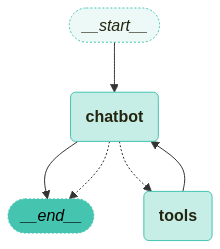

In [91]:
visualize_graph(graph)

In [92]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig
import json

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

# config 설정
config = RunnableConfig(
    recursion_limit=10,             
    configurable={"thread_id": thread_id},  
    tags=["data-tag"],                  
)

question = '대구 맛집을 알려줘?'

state = State(messages=[('user', question)])

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] content: {value['messages'][-1].content}")

            if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                print('tool call 있음')

                tool_result = value['messages'][-1].tool_calls

                print(f"도구 이름 : {tool_result[0]['name']}")
                print(f"도구 인자: {tool_result[0]['args']}")            
            else:
                print('tool call 없음')                
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content : \n{value['messages'][-1].content}")
            # print(f"[해당 노드 값] 도구 name : {value['messages'][-1].name}")
            print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:                
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

thread_id: 411326
===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='대구 맛집을 알려줘?' additional_kwargs={} response_metadata={} id='29d05693-ad15-498f-8b64-92d2a0ff3eb2'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_j79yvnjdMfVexrAbyufJfnTd', 'function': {'arguments': '{"query":"대구 맛집"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5ae63566-a6de-42b2-a34c-8615d3838b58-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'que

In [93]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

question = ('`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.' additional_kwargs={} response_metadata={} id='79b63abb-52a5-4e87-9c30-3f68b4958c6f'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None} id='run-64709124-cf5c-4171-b4e4-7d0bb8df6122-0' usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0,

In [94]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

snapshot = graph.get_state(config=config)

In [95]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='79b63abb-52a5-4e87-9c30-3f68b4958c6f'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-64709124-cf5c-4171-b4e4-7d0bb8df6122-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 

In [96]:
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f006285-8655-6b9e-8001-0e1620b3f7f3'}}

In [97]:
snapshot.values

{'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='79b63abb-52a5-4e87-9c30-3f68b4958c6f'),
  AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-64709124-cf5c-4171-b4e4-7d0bb8df6122-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [98]:
snapshot.next

()

In [99]:
snapshot.metadata

{'source': 'loop',
 'writes': {'chatbot': {'messages': [AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-64709124-cf5c-4171-b4e4-7d0bb8df6122-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}},
 'thread_id': '1',
 'step': 1,
 'parents': {}}

In [100]:
snapshot.metadata['writes']['chatbot']['messages'][0]

AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-64709124-cf5c-4171-b4e4-7d0bb8df6122-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [101]:
from langchain_teddynote.messages import display_message_tree

display_message_tree(snapshot.metadata)

    source: "loop"
    writes:
        chatbot:
            messages:
                index [0]
                    content: "안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!"
                    additional_kwargs: {"refusal": None}
                    response_metadata:
                        token_usage:
                            completion_tokens: 57
                            prompt_tokens: 110
                            total_tokens: 167
                            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
                            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
                        model_name: "gpt-4o-mini-2024-07-18"
                        system_fingerprint: "fp_b8bc95a0ac"
                        finish_reason: "stop"
                        logprobs: None
                    type: "ai"
       